# Trabajo Práctico 2: Análisis con Stacking - Organización de Datos

**Alumnos y Padrón**  
* Grassano, Bruno - 103855  
* Romero, Adrián   - 103371

https://github.com/brunograssano/TP-Organizacion-de-datos

## Importamos las bibiliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import tree

In [14]:
from preprocessing import prepararSetDeDatos
from preprocessing import prepararSetDeValidacion
from preprocessing import prepararSetDeHoldout
from preprocessing import conversionAVariablesNumericasNormalizadas
from preprocessing import conversionAVariablesNumericas
from preprocessing import expansionDelDataset

In [5]:
from funcionesAuxiliares import mostrarAUCScore
from funcionesAuxiliares import mostrarROCCurve
from funcionesAuxiliares import mostrarMatrizDeConfusion
from funcionesAuxiliares import escribirPrediccionesAArchivo
from funcionesAuxiliares import obtenerDatasets
from funcionesAuxiliares import obtenerHoldout

## Importamos los datos y los procesamos

In [6]:
X, y = obtenerDatasets()
X = prepararSetDeDatos(X)
y = prepararSetDeValidacion(y)

## Stacking

Este modelo es un ensamble que consiste en la unión de varios modelos. Lo que se hace es ir apilando la salida de cada estimador individual y usar un clasificador final que va a computar la predicción final. Esto permite usar las ventajas de cada estimador individual.

Los elegidos fueron:
 * Árbol de decisión
 * SVM
 * Random Forest
 * Regresión logística

Cada uno de estos modelos lo recreamos con los mejores hiperparámetros que se encontraron en su notebook.

Para el preprocesamiento se decidió utilizar el mismo que para regresión logística y SVM, asi obtienen sus mejores resultados devuelta.

In [7]:
X_voting = conversionAVariablesNumericasNormalizadas(X)

Dividimos el set de datos en sets de training y test.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_voting, y, test_size=0.25, random_state=0)

Inicializamos los modelos que usarán en el Stacking, cada uno con sus mejores hiperparámetros encontrados. En el caso de random forest se les redujo algo la profundidad.

In [9]:
regresion_logistica = LogisticRegression(penalty = 'none', solver = "saga",max_iter = 5000)
random_forest = RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy',max_depth=7)
svm = SVC(C=200, kernel='rbf', gamma=0.1,probability=True)
arbol = tree.DecisionTreeClassifier(random_state=117, max_depth=4, criterion = 'gini')

estimadores = [('svm',svm),('tree',arbol),('rf', random_forest),('rl',regresion_logistica)]

Creamos el modelo y lo entrenamos.

In [10]:
stacking = StackingClassifier(estimators=estimadores,n_jobs=-1)

In [11]:
stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('svm', SVC(C=200, gamma=0.1, probability=True)),
                               ('tree',
                                DecisionTreeClassifier(max_depth=4,
                                                       random_state=117)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       random_state=0)),
                               ('rl',
                                LogisticRegression(max_iter=5000,
                                                   penalty='none',
                                                   solver='saga'))],
                   n_jobs=-1)

Buscamos también un modelo de stacking que utilice el dataset expandido y los mejores parámetros que se obtuvieron cuando se utilizó esta expansión en sus respectivos notebooks:

In [12]:
regresion_logistica = LogisticRegression(penalty = 'none', solver = "saga",max_iter = 5000)
random_forest = RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy',max_depth=7)
svm = SVC(C=200, kernel='rbf', gamma=0.1,probability=True)
arbol = tree.DecisionTreeClassifier(random_state=117, max_depth=4, criterion = 'entropy')

estimadores = [('svm',svm),('tree',arbol),('rf', random_forest),('rl',regresion_logistica)]

In [16]:
X_expandido = expansionDelDataset(X)

columnas_codificables_extra = ['pago_categorizado','edades_estratificadas','categoria_invitados']
columnas_numericas_extra = ['4_clusters','10_clusters','total_pagado']

nombre_de_los_features_expandidos, X_arbol_expandido  = conversionAVariablesNumericas(X_expandido,columnas_codificables_extra,columnas_numericas_extra)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_arbol_expandido, y, test_size=0.25, random_state=0)

In [18]:
stacking_exp = StackingClassifier(estimators=estimadores,n_jobs=-1)

In [19]:
stacking_exp.fit(X_exp_train, y_exp_train)

StackingClassifier(estimators=[('svm', SVC(C=200, gamma=0.1, probability=True)),
                               ('tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=4,
                                                       random_state=117)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       random_state=0)),
                               ('rl',
                                LogisticRegression(max_iter=5000,
                                                   penalty='none',
                                                   solver='saga'))],
                   n_jobs=-1)

#### Evaluación de métricas

Ahora si, realizamos las predicciones y observamos las métricas.

In [22]:
y_pred = stacking.predict(X_test)
y_exp_pred = stacking_exp.predict(X_exp_test)

In [24]:
print(classification_report(y_test, y_pred, target_names=['No vuelve','Vuelve']))
print(classification_report(y_exp_test, y_exp_pred, target_names=['No vuelve','Vuelve']))

              precision    recall  f1-score   support

   No vuelve       0.83      0.91      0.87       121
      Vuelve       0.84      0.72      0.78        80

    accuracy                           0.84       201
   macro avg       0.84      0.82      0.82       201
weighted avg       0.84      0.84      0.83       201

              precision    recall  f1-score   support

   No vuelve       0.84      0.88      0.86       121
      Vuelve       0.81      0.74      0.77        80

    accuracy                           0.83       201
   macro avg       0.82      0.81      0.82       201
weighted avg       0.82      0.83      0.82       201



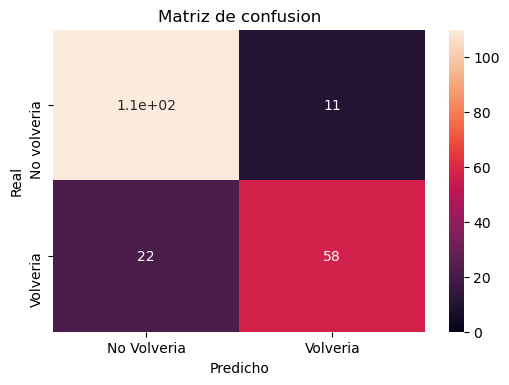

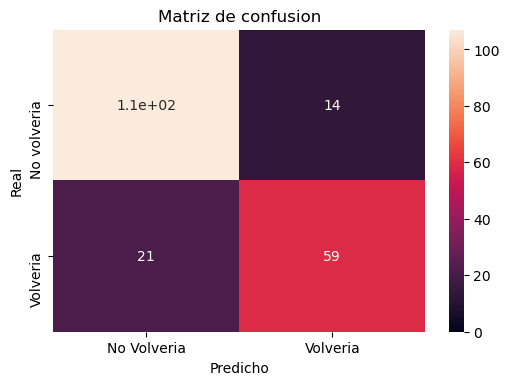

In [25]:
mostrarMatrizDeConfusion(y_pred,y_test)
mostrarMatrizDeConfusion(y_exp_pred,y_exp_test)

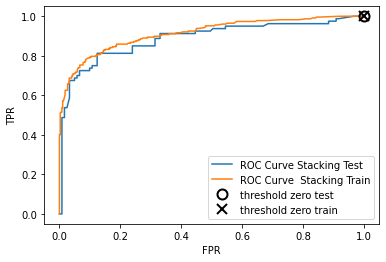

In [26]:
mostrarROCCurve(stacking,"Stacking",X_test,X_train,y_test,y_train)

In [27]:
mostrarAUCScore(stacking,"Stacking",X_test,y_test)
mostrarAUCScore(stacking1,"Stacking",X_test,y_test)

AUC para Stacking: 0.887


Usando este modelo se llegó a un muy buen resultado, casi alcanzando al obtenido con Voting.

## Predicciones sobre el nuevo archivo

Realizamos ahora las predicciones del nuevo archivo entregado.

In [ ]:
holdout = obtenerHoldout()

holdout = prepararSetDeHoldout(holdout)
holdout_stacking = conversionAVariablesNumericasNormalizadas(holdout)

Realizamos las predicciones y escribimos al archivo CSV.

In [ ]:
predicciones_holdout = stacking.predict(holdout_stacking)

In [ ]:
escribirPrediccionesAArchivo(predicciones_holdout,"Stacking")